In [ ]:
import pandas as pd                         # Импортируем библиотеку для работы с таблицами и данными
import numpy as np                          # Импортируем библиотеку для численных операций с массивами
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Для кодирования категориальных меток
from sklearn.model_selection import train_test_split            # Для разделения данных на обучающую и тестовую выборки
from tensorflow.keras.models import Sequential                   # Для создания последовательных моделей нейронных сетей
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Masking  # Слои для рекуррентных сетей и др.
from tensorflow.keras.utils import to_categorical                 # Для преобразования меток в one-hot формат
from sklearn.metrics import classification_report, confusion_matrix  # Для оценки качества классификации
import matplotlib.pyplot as plt                                   # Для построения графиков
import seaborn as sns                                             # Для улучшенной визуализации графиков

In [ ]:
# 1. ЗАГРУЗКА ДАННЫХ
df = pd.read_csv('data.csv', on_bad_lines='skip') # считываем данные пропуская проблемные строчки
print(df.head(5))

   id  expiration_id     src_ip            src_mac   src_oui  src_port  \
0   0              0  10.1.1.11  fa:16:3e:2c:fe:de  fa:16:3e     47794   
1   1              0   10.1.1.4  fa:16:3e:03:f9:45  fa:16:3e       123   
2   2              0   10.1.1.6  fa:16:3e:d9:a8:74  fa:16:3e       123   
3   3              0   10.1.1.4  fa:16:3e:03:f9:45  fa:16:3e       123   
4   4              0   10.1.1.6  fa:16:3e:d9:a8:74  fa:16:3e       123   

           dst_ip            dst_mac   dst_oui  dst_port  ...  \
0   35.232.111.17  fa:16:3e:e5:11:55  fa:16:3e        80  ...   
1  138.236.128.36  fa:16:3e:e5:11:55  fa:16:3e       123  ...   
2  27.124.125.252  fa:16:3e:e5:11:55  fa:16:3e       123  ...   
3   45.79.214.107  fa:16:3e:e5:11:55  fa:16:3e       123  ...   
4   204.11.201.12  fa:16:3e:e5:11:55  fa:16:3e       123  ...   

   application_is_guessed          requested_server_name  client_fingerprint  \
0                       0  connectivity-check.ubuntu.com                 NaN   
1   

In [ ]:
# 2. ОЧИСТКА ДАННЫХ
useful_cols = [
    'src_ip', 'user_agent', 'Activity', 'Stage',
    'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
    'src2dst_packets', 'dst2src_packets'
]  # Определяем полезные столбцы (идентификаторы и числовые признаки)

df = df[useful_cols]        # Оставляем в датафрейме только эти столбцы
df.dropna(inplace=True)     # Удаляем строки с пропущенными значениями

<ipython-input-3-347fe75b5783>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)     # Удаляем строки с пропущенными значениями


In [ ]:
# 3. ГРУППИРОВКА ПО СЕССИЯМ
# Группируем события по уникальным сессиям (IP + агент)
session_groups = df.groupby(['src_ip', 'user_agent'])

def make_sequences(group):
    # Максимум 10 событий в сессии для примера
    max_seq_len = 10
    seq = group[['bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
                 'src2dst_packets', 'dst2src_packets']].values # Берём числовые признаки из группы событий

    if len(seq) > max_seq_len: # Если событий больше 10, обрезаем до первых 10
        seq = seq[:max_seq_len]
    else:
        padding = np.zeros((max_seq_len - len(seq), seq.shape[1])) # Иначе дополняем нулями для выравнивания длины
        seq = np.vstack([seq, padding])

    activity = group['Activity'].iloc[0] # Метка активности сессии (например, Normal или APT) берётся из первого события
    stage = group['Stage'].iloc[0]  # Метка этапа атаки тоже из первого события
    return seq, activity, stage

sequences = [] # Список для хранения последовательностей признаков
activities = [] # Метки активности
stages = [] # Метки этапов атаки

for _, group in session_groups:  # Для каждой сессии
    seq, act, stg = make_sequences(group) # формируем последовательность признаков и меток
    sequences.append(seq)
    activities.append(act)
    stages.append(stg)

X = np.array(sequences)  # Массив с последовательностями признаков: (число сессий, длина seq, число признаков)
y_activity = np.array(activities) # Метки активности (Normal/APT)
y_stage = np.array(stages)   # Метки этапов атаки

In [ ]:
# 4. КОДИРОВКА МЕТОК
 # Создаём кодировщик для активности (бинарная классификация)
le_activity = LabelEncoder()
y_activity_enc = le_activity.fit_transform(y_activity)  # Преобразуем метки в числа (0 и 1)

unique_stages = sorted(set(y_stage))  # Находим уникальные этапы атаки
stage_to_index = {stg: idx for idx, stg in enumerate(unique_stages)} # Создаём словарь: этап -> индекс
y_stage_enc = np.array([stage_to_index[stg] for stg in y_stage]) # Преобразуем этапы в индексы
y_stage_onehot = to_categorical(y_stage_enc, num_classes=len(unique_stages)) # В one-hot формат

In [ ]:
# 5. РАЗДЕЛЕНИЕ НА ОБУЧЕНИЕ И ТЕСТ
X_train, X_test, y_train, y_test = train_test_split(X, y_activity_enc, test_size=0.2, random_state=42)

In [ ]:
# 6. ПОСТРОЕНИЕ МОДЕЛИ LSTM для бинарной классификации
model = Sequential()  # Создаём последовательную модель нейросети
model.add(Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2]))) # Маскирование padding (нулевых значений)
model.add(LSTM(64, return_sequences=False))  # LSTM-слой с 64 нейронами
model.add(Dropout(0.3)) # Dropout для регуляризации (предотвращение переобучения)
model.add(Dense(1, activation='sigmoid'))   # Выходной слой для бинарной классификации (0 или 1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Компилируем модель

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 7. ОБУЧЕНИЕ
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2) # Обучаем с 10 эпохами и валидацией

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5000 - loss: 0.9280 - val_accuracy: 0.0000e+00 - val_loss: 1.3021
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5000 - loss: 0.8472 - val_accuracy: 0.0000e+00 - val_loss: 1.2899
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3333 - loss: 0.9068 - val_accuracy: 0.0000e+00 - val_loss: 1.2776
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5000 - loss: 0.9316 - val_accuracy: 0.0000e+00 - val_loss: 1.2655
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5000 - loss: 0.8422 - val_accuracy: 0.0000e+00 - val_loss: 1.2537
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5000 - loss: 0.9831 - val_accuracy: 0.0000e+00 - val_loss: 1.2430
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5000 - loss: 0.7640 - val_accuracy: 0.0000e+00 - val_loss: 1.2383
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6667 - loss: 0.8395 - val_accu

In [ ]:
# 8. ОЦЕНКА НА ТЕСТЕ
y_pred_prob = model.predict(X_test)  # Предсказываем вероятности классов
y_pred = (y_pred_prob > 0.5).astype(int).flatten() # Преобразуем вероятности в бинарные метки

print(classification_report(y_test, y_pred, labels=[0,1], target_names=le_activity.classes_)) # передаём список меток в classification_report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.50      0.67         2

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to con

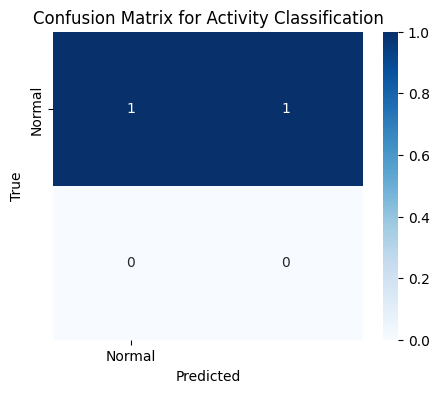

In [ ]:
# 9. ВИЗУАЛИЗАЦИЯ CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)  # Строим матрицу ошибок (TP, FP, FN, TN)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # Визуализация матрицы ошибок
            xticklabels=le_activity.classes_, yticklabels=le_activity.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Activity Classification')
plt.show()

In [ ]:
# 10. АНАЛИЗ ЛОЖНОПОЗИТИВНЫХ И ЛОЖНООТРИЦАТЕЛЬНЫХ СЕССИЙ
fp_idx = np.where((y_test == 0) & (y_pred == 1))[0] # Индексы случаев, когда нормальное поведение ошибочно определили как атаку
fn_idx = np.where((y_test == 1) & (y_pred == 0))[0]  # Индексы случаев, когда атаку пропустили (ошибка)

print(f'False Positives examples (Normal classified as Attack): {fp_idx}')
print(f'False Negatives examples (Attack classified as Normal): {fn_idx}')

False Positives examples (Normal classified as Attack): [1]
False Negatives examples (Attack classified as Normal): []


In [ ]:
# 11. MULTI-LABEL МОДЕЛЬ ДЛЯ STAGE (этапов атаки)
# Делим выборки для multi-label
X_train_stg, X_test_stg, y_train_stg, y_test_stg = train_test_split(X, y_stage_onehot, test_size=0.2, random_state=42) # Для этапов атаки

model_stage = Sequential()
model_stage.add(Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2])))
model_stage.add(GRU(64, return_sequences=False))  # Используем GRU вместо LSTM
model_stage.add(Dropout(0.3))
model_stage.add(Dense(len(unique_stages), activation='softmax'))  # Многоклассовый выход для этапов
model_stage.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_stage = model_stage.fit(X_train_stg, y_train_stg, epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 1.0000 - loss:

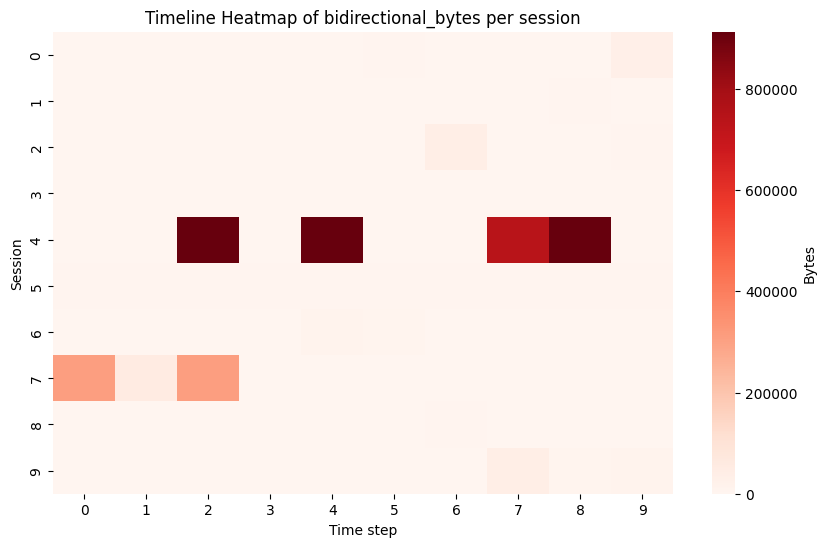

In [ ]:
# 12. Визуализация timeline heatmap по действиям атакующего
# Для упрощения — визуализируем сумму bidirectional_bytes по сессиям и шагам
# Можно расширить до разных признаков, отсортировав по времени

# Создадим датафрейм для heatmap (сессия x временной шаг)
heatmap_data = []
for seq in X:
    heatmap_data.append(seq[:, 2])  # Берём признак bidirectional_bytes для каждого временного шага

heatmap_data = np.array(heatmap_data)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='Reds', cbar_kws={'label': 'Bytes'})
plt.xlabel('Time step')
plt.ylabel('Session')
plt.title('Timeline Heatmap of bidirectional_bytes per session')
plt.show()